# Machine Learning -- Crypto Arbitrage Analysis
This notebook investigates the use of machine learning and data mining techniques to predict arbitrage opportunities in cryptocurrency markets. Using data collected through CoinAPI & XChangeAPI websockets, this research is part of my senior thesis project in Economics on "Arbitrage in the cryptocurrency market".

## DATASET
The dataset tracks the price of Bitcoin and Ethereum across multiple exchanges (Coinbase, Binance, Kraken, Bitstamp) and fiat currency markets (USD, EUR, GBP) along with exchange rates. It includes computed arbitrage percentages, execution strategies, and profit calculations after accounting for exchange fees.

## SOURCE
Data was collected via websockets over a 5-day period (May 22-26, 2025) and stored in CSV files.

## Research Goals
- Classify the most profitable arbitrage strategy route based on current market conditions
- Predict whether the next timestamp will present a profitable arbitrage opportunity
- Identify if price points in specific markets are diverging from or converging to cross-market means
- Evaluate how vulnerable arbitrage opportunities are to latency risks

## DATASET SCALE
    28,006,444 instances
    17 raw features + 4 transformation features

## Focus and Scope
- *Although the original data contains multiple fiat currencies, this analysis focuses on USD markets only (COINBASE_USD, BINANCE_USD, etc.)*
- *While the dataset contains both ETH and BTC data, this notebook focuses exclusively on Bitcoin*

In [2]:
import pandas as pd

missing_values = ["?"]

# Load the training data
# I've added column headings
# I've added the missing value string
# and in order to make that work, I've skipped the initial space

df0 = pd.read_csv("data/crypto_arbitrage_3_2025-05-22.csv",
                        #   names=labels,
                          na_values = missing_values,
                          skipinitialspace=True)

df1 = pd.read_csv("data/crypto_arbitrage_3_2025-05-23.csv",
                        #   names=labels,
                          na_values = missing_values,
                          skipinitialspace=True)

df2 = pd.read_csv("data/crypto_arbitrage_3_2025-05-24.csv",
                        #   names=labels,
                          na_values = missing_values,
                          skipinitialspace=True)

df3 = pd.read_csv("data/crypto_arbitrage_3_2025-05-25.csv",
                        #   names=labels,
                          na_values = missing_values,
                          skipinitialspace=True)

df4 = pd.read_csv("data/crypto_arbitrage_3_2025-05-26.csv",
                        #   names=labels,
                          na_values = missing_values,
                          skipinitialspace=True)


df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

pre_rows,pre_cols = df.shape
print("This is the crypto-currency data set. It has", pre_rows, "instances, and it has", pre_cols, "features.\n\n")

# Show the head of the data
df.head()

This is the crypto-currency data set. It has 28006444 instances, and it has 21 features.




,crypto,timestamp,COINBASE_USD,COINBASE_EUR,COINBASE_GBP,BINANCE_USD,BINANCE_EUR,BINANCE_GBP,KRAKEN_USD,KRAKEN_EUR,...,BITSTAMP_USD,BITSTAMP_EUR,BITSTAMP_GBP,USD_RATE/USD,EUR_RATE/USD,GBP_RATE/USD,strategy,arbitrage,total_fees,arbitrage_after_fees
0,BTC,2025-05-22 15:14:39,111803.72,NaN,NaN,111750.15,99007.89,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.1281,1.3427,Buy at BINANCE in EUR -> Sell at COINBASE in USD,0.10%,$16.75,$94.19
1,BTC,2025-05-22 15:14:39,111803.72,NaN,NaN,111750.15,99007.89,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.1281,1.3427,Buy at BINANCE in EUR -> Sell at COINBASE in USD,0.10%,$16.75,$94.19
2,BTC,2025-05-22 15:14:39,111803.72,NaN,NaN,111750.15,99007.89,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.1281,1.3427,Buy at BINANCE in EUR -> Sell at COINBASE in USD,0.10%,$16.75,$94.19
3,BTC,2025-05-22 15:14:39,111803.72,NaN,NaN,111750.15,99007.89,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.1281,1.3427,Buy at BINANCE in EUR -> Sell at COINBASE in USD,0.10%,$16.75,$94.19
4,BTC,2025-05-22 15:14:39,111803.72,NaN,NaN,111750.15,99007.89,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.1281,1.3427,Buy at BINANCE in EUR -> Sell at COINBASE in USD,0.10%,$16.75,$94.19


## Data Loading and Initial Exploration
Loading the dataset from five separate CSV files covering a 5-day period (May 22-26, 2025). Each file contains cryptocurrency price data from different exchanges and arbitrage-related information. We'll concatenate these files into a single dataframe for analysis.

In [ ]:
# Drop all rows with ETH in the crypto column
pre_rows, pre_cols = df.shape

df = df[df["crypto"] != "ETH"]


print("Before dropping all rows with ETH in the crypto column, the data set has", pre_rows, "instances, and it has", pre_cols, "features.\n\n")

print("\n\nAfter dropping all rows with ETH in the crypto column, the data set has", df.shape[0], "instances, and it has", df.shape[1], "features.\n\n")

percent_lost = (pre_rows - df.shape[0]) / pre_rows * 100
print(f"{percent_lost:.2f}% of the dataset was lost after dropping all ETH rows.\n")

# Dropping the crypto column since all rows are for BTC only
df.drop(columns=["crypto"], inplace=True)

df.head()


## Filtering to Bitcoin-Only Data
As mentioned earlier, we'll focus exclusively on Bitcoin data by filtering out all Ethereum (ETH) records. After filtering, we'll drop the 'crypto' column since all remaining records will be for Bitcoin only.

In [ ]:
df.dtypes

## Doing some Data analysis

Looking over the missing data instances for each feature

In [ ]:
# Plot missing data
import missingno as msno

msno.matrix(df)

## Missing data analysis
Based on the missing data analysis, the BINANACE_GBP feature never has a single value and therefore can easily be dropped as it provides no contribution to the analysis. Additionally, based on the nature of the data collection, we can also safely remove all rows with an NA value after dropping the BINANCE_GBP feature since the missing values will only occur in the start of the dataset.

In [ ]:
# Dropping the BINANCE_GBP feaure from the data set
pre_rows, pre_cols = df.shape

df = df.drop(columns=['BINANCE_GBP'])


print("\nDropping all instances with NaN values\n")

df = df.dropna()
post_rows,post_cols = df.shape
df_per = (pre_rows - post_rows) / pre_rows * 100

print("After dropping NaN values, the data set has", post_rows, "instances, and it has", post_cols, "features.\n")
print("This means that", round(df_per, 2), "% of the data was dropped.\n")
# Show the head of the cleaned data
df.head()

In [ ]:
df.info()

## Data Structure and Types
Checking the data types and structure to ensure all features are properly formatted before proceeding with further analysis.

In [ ]:
df.describe(include='all')

## Statistical Summary
Generating descriptive statistics for all features to understand their distributions, ranges, and central tendencies. This will help identify outliers and understand the scale of our cryptocurrency price data.

## Drop non-USD columns
Since we are working with only USD price points, the arbitrage module is limited to only exchange arbitrage and thus we can drop all the non-USD columns from the dataset


In [ ]:
non_usd_columns = [column for column in df.columns if column.endswith('_GBP') or column.endswith('_EUR')]
print("\nThe following columns are not in USD:\n")
for column in non_usd_columns:
    print(column)

df = df.drop(columns=non_usd_columns)
print("\nDropping the non-USD columns\n")
print("After dropping the non-USD columns, the data set has", df.shape[0], "instances, and it has", df.shape[1], "features.\n")
# Show the head of the cleaned data
df.head()

In [ ]:
# Drop the exchange rate columns for EUR/USD and GBP/USD
df = df.drop(columns=['EUR_RATE/USD', 'GBP_RATE/USD', 'USD_RATE/USD'])
print("\nDropping the EUR_USD and GBP_USD columns\n")
print("After dropping the EUR_USD and GBP_USD columns, the data set has", df.shape[0], "instances, and it has", df.shape[1], "features.\n")
# Show the head of the cleaned data
df.head()


## Data cleaning
Replacing all the previously trasnformed columns with new ones that extend to only the scope of this experiment which is exchange only arbitrage
Replacing all object integers with \$ to an int by removing the \$

In [ ]:
from fee_calc import FeeCalculator

def get_min_max_prices_row(row, columns):
    """
    Given a row (Series) and a list of columns, return the lowest price, highest price,
    and their respective column names (exchange only, without '_USD').

    Returns:
        min_price (float): The lowest price value.
        min_col (str): The exchange name with the lowest price.
        max_price (float): The highest price value.
        max_col (str): The exchange name with the highest price.
    """
    prices = row[columns]
    min_col = prices.idxmin()
    min_price = prices[min_col]
    max_col = prices.idxmax()
    max_price = prices[max_col]
    # Only keep the exchange name before '_USD'
    min_col_short = min_col.split('_USD')[0]
    max_col_short = max_col.split('_USD')[0]
    return {
        "min_price": min_price,
        "min_col": min_col_short,
        "max_price": max_price,
        "max_col": max_col_short
    }

def calculate_arbitrage(row):
    """
    Calculate arbitrage opportunity and fees for a given row of data
    
    Args:
        row: DataFrame row containing price data for different exchanges
    
    Returns:
        Dictionary with arbitrage details: strategy, arbitrage percentage, total fees, 
        and arbitrage after fees
    """
    # Get USD price columns
    usd_columns = [col for col in row.index if col.endswith('_USD')]
    
    # Get min and max prices
    price_info = get_min_max_prices_row(row, usd_columns)
    
    # Extract values
    min_price = price_info["min_price"]
    min_exchange = price_info["min_col"]
    max_price = price_info["max_price"]
    max_exchange = price_info["max_col"]
    
    # Calculate raw arbitrage (before fees)
    raw_arbitrage = max_price - min_price
    arbitrage_pct = (raw_arbitrage / min_price) * 100
    
    
    # Initialize fee calculator
    # Using 1 BTC as standard amount for calculation
    crypto_amount = 1.0
    
    fee_calc = FeeCalculator(
        exchange_buy=min_exchange,
        exchange_sell=max_exchange,
        crypto="BTC",
        crypto_amount=crypto_amount,
        crypto_price_buy=min_price,
        crypto_price_sell=max_price,
        currency_withdrawal="USD",
        exchange_rates={"USD": 1.0}  # Not needed for USD-only calculations
    )
    
    # Calculate fees
    fees = fee_calc.calculate_fees()
    
    # Construct strategy string: BUY@exchange1->SELL@exchange2
    strategy = f"BUY@{min_exchange}->SELL@{max_exchange}"
    
    return {
        "strategy": strategy if fees["arbitrage_after_fees"] > 0 else "No profitable arbitrage",
        "arbitrage(%)": arbitrage_pct,
        "total_fees": fees["total_fees"],
        "arbitrage_after_fees": fees["arbitrage_after_fees"]
    }

## Arbitrage Calculation Functions

These helper functions are used to identify arbitrage opportunities between different exchanges:

1. `get_min_max_prices_row`: Identifies which exchange has the lowest and highest prices for a given cryptocurrency
2. `calculate_arbitrage`: Computes the potential profit from an arbitrage opportunity, accounting for all fees

These calculations form the foundation of our prediction task - we want to predict which arbitrage strategy (which pair of exchanges) will be most profitable in the next time period.

Since each row reflects a new heartbeat from the websocket, there are multiple rows with the same timestamp exact to the milisecond, which really is counter intuitive when looking at a new feature such as change in price or even some variable_(t+1). Hence, some cleaning needs to be done by essentially only keeping the last row that appears in the dataset for each unique timestamp.

In [ ]:

pre_dedup_count = len(df)

df = df.drop_duplicates(subset=['timestamp'], keep='last')

post_dedup_count = len(df)
rows_removed = pre_dedup_count - post_dedup_count

print(f"Before removing duplicate timestamps: {pre_dedup_count} rows")
print(f"After keeping only the last row per timestamp: {post_dedup_count} rows")
print(f"Removed {rows_removed} duplicate timestamp rows ({rows_removed/pre_dedup_count:.2%} of data)")


## Timestamp Deduplication

The websocket data collection process can sometimes produce multiple records with the same timestamp (to the millisecond). For time series analysis and feature engineering purposes, we need one unique record per timestamp.

We'll keep only the last record for each timestamp, which represents the most recent state of the market at that exact moment.

In [ ]:
# Removing the un-raw data
df = df.drop(columns=['strategy', 'arbitrage', 'total_fees', 'arbitrage_after_fees'])

df.to_csv("cleaned_crypto_arbitrage_intermediate.csv", index=False)

## Saving Intermediate Cleaned Data

After performing initial data cleaning, we'll save this intermediate dataset to disk. This allows us to quickly reload the cleaned data for future analysis without repeating the cleaning steps.

In [4]:
df = pd.read_csv("cleaned_crypto_arbitrage_with_fees.csv")
df.head()

,timestamp,COINBASE_USD,BINANCE_USD,KRAKEN_USD,BITSTAMP_USD,strategy,arbitrage(%),total_fees,arbitrage_after_fees
0,2025-05-22 15:23:30,111821.43,111775.73,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055710,50.318759,11.951241
1,2025-05-22 15:23:31,111821.43,111775.74,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239
2,2025-05-22 15:23:32,111821.43,111775.74,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239
3,2025-05-22 15:23:33,111821.44,111775.73,111734.7,111838.0,No profitable arbitrage,0.092451,212.327920,-109.027920
4,2025-05-22 15:23:34,111821.44,111775.74,111779.9,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239


## Loading Pre-processed Data with Fee Calculations

Rather than recalculating all arbitrage metrics and fees in this notebook, we're loading a pre-processed version of the dataset that already includes these calculations. This file was likely created in a separate process using the `fee_calc.py` module.

In [5]:
# Create a new feature for if arbitrage is profitable or not

# df['Profitable'] = df['arbitrage_after_fees'] > 0

# # Apply the condition row by row using numpy.where
# df['profitable_strategy'] = np.where(df['Profitable'], df['strategy'], 'None')

# Extract the strategy in the next timestamp (recompute after updating strategy)
df['next_strategy'] = df['strategy'].shift(-1)


# Display a sample of the results
# print("\nSample of rows with profitable arbitrage:")
# sample_profitable = df[df['Profitable']].sample(min(5, len(df[df['Profitable']])))
# print(sample_profitable[['strategy', 'arbitrage(%)', 'total_fees', 'arbitrage_after_fees']])


# remove the "$" from the arbitrage_after_fees column
df['arbitrage_after_fees'] = df['arbitrage_after_fees'].replace({'\$': ''}, regex=True).astype(float)

df['arbitrage(%)'] = df['arbitrage(%)'].replace({'\%': ''}, regex=True).astype(float)

df['total_fees'] = df['total_fees'].replace({'\$': ''}, regex=True).astype(float)

df.head()

<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:21: SyntaxWarning: invalid escape sequence '\%'
<>:23: SyntaxWarning: invalid escape sequence '\$'
/var/folders/6r/tt837lfn3tb95bbpc6gpjylr0000gq/T/ipykernel_48374/2836086145.py:19: SyntaxWarning: invalid escape sequence '\$'
  df['arbitrage_after_fees'] = df['arbitrage_after_fees'].replace({'\$': ''}, regex=True).astype(float)
/var/folders/6r/tt837lfn3tb95bbpc6gpjylr0000gq/T/ipykernel_48374/2836086145.py:21: SyntaxWarning: invalid escape sequence '\%'
  df['arbitrage(%)'] = df['arbitrage(%)'].replace({'\%': ''}, regex=True).astype(float)
/var/folders/6r/tt837lfn3tb95bbpc6gpjylr0000gq/T/ipykernel_48374/2836086145.py:23: SyntaxWarning: invalid escape sequence '\$'
  df['total_fees'] = df['total_fees'].replace({'\$': ''}, regex=True).astype(float)


,timestamp,COINBASE_USD,BINANCE_USD,KRAKEN_USD,BITSTAMP_USD,strategy,arbitrage(%),total_fees,arbitrage_after_fees,next_strategy
0,2025-05-22 15:23:30,111821.43,111775.73,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055710,50.318759,11.951241,BUY@BINANCE->SELL@BITSTAMP
1,2025-05-22 15:23:31,111821.43,111775.74,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239,BUY@BINANCE->SELL@BITSTAMP
2,2025-05-22 15:23:32,111821.43,111775.74,111780.0,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239,No profitable arbitrage
3,2025-05-22 15:23:33,111821.44,111775.73,111734.7,111838.0,No profitable arbitrage,0.092451,212.327920,-109.027920,BUY@BINANCE->SELL@BITSTAMP
4,2025-05-22 15:23:34,111821.44,111775.74,111779.9,111838.0,BUY@BINANCE->SELL@BITSTAMP,0.055701,50.318761,11.941239,BUY@BINANCE->SELL@BITSTAMP


## Creating Target Variable and Cleaning String Formats

In this step, we're preparing our target variable for prediction:

1. Creating 'next_strategy' column by shifting the 'strategy' column to represent the arbitrage strategy in the subsequent time period
2. Cleaning string formatting by removing currency symbols ($ and %) to convert to proper numeric data types

The 'next_strategy' column will be our target variable for the classification task - we want to predict which arbitrage strategy will be optimal in the next time period.

### Data Analysis of the distribution of strategies


Strategy counts:
 strategy
No profitable arbitrage        72504
BUY@BINANCE->SELL@COINBASE     21632
BUY@BINANCE->SELL@BITSTAMP     15598
BUY@BITSTAMP->SELL@COINBASE     2192
BUY@COINBASE->SELL@BITSTAMP      510
BUY@COINBASE->SELL@BINANCE       353
BUY@BITSTAMP->SELL@BINANCE       170
BUY@BINANCE->SELL@KRAKEN          65
BUY@KRAKEN->SELL@COINBASE         64
BUY@KRAKEN->SELL@BITSTAMP         34
BUY@COINBASE->SELL@KRAKEN         12
BUY@KRAKEN->SELL@BINANCE          12
BUY@BITSTAMP->SELL@KRAKEN          6
Name: count, dtype: int64


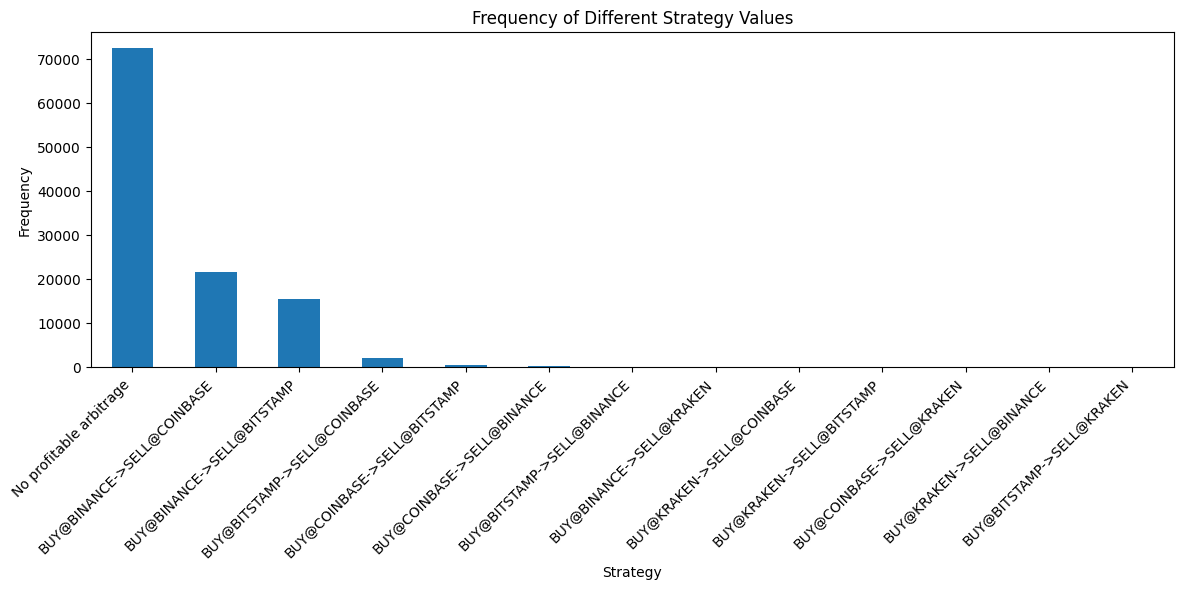

In [6]:
import matplotlib.pyplot as plt

# Count the frequency of each strategy value
strategy_counts = df['strategy'].value_counts(dropna=False)
print("\nStrategy counts:\n", strategy_counts)
# Set up the plot style

# Plot as a bar chart
plt.figure(figsize=(12,6))
strategy_counts.plot(kind='bar')
plt.xlabel('Strategy')
plt.ylabel('Frequency')
plt.title('Frequency of Different Strategy Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Label Encoding & Transformation
- Deriving different date, time, day and hour features from the timestamp
- Deriving a boolean feature if the arbitrage after fees is profitable or not
- Derive feature for the strategy -> the strategy being the strategy if the arbitrage_after_fees > 0
- Normalize all prices to USD but keep the tag to know which market the price point came from
- Extract the variance of the the following
    - variance in exchange from the last 30 timestamps
    - variance in fiat currency from the last 30 timestamps
- Extract the change in price for each price point
- ! Replace the strategy feature to capture only exchange arbitrage -- use external modules to calculate the arbitrage along with arbitrage after fees aswell as total fees again for this new condition !
- Encode the next strategy in it's own feature. Hence Strategy_t+1


In [7]:
# Encode the Timestamp column to datetime and create a feature for the hour, minute, and day of the week
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['Hour'] = df['timestamp'].dt.hour
df['Minute'] = df['timestamp'].dt.minute
df['DayOfWeek'] = df['timestamp'].dt.dayofweek
# Drop the original Timestamp column
df = df.drop(columns=['timestamp'])


In [8]:
# # -----------This cell does not need to be run for this smaller version of the experiment with exchange only arbitrage-----------

# # Convert all price points to USD
# # For USD prices, no conversion needed
# # For EUR prices, multiply by EUR_RATE/USD
# # For GBP prices, multiply by GBP_RATE/USD

# # COINBASE conversions
# df['COINBASE_EUR_USD'] = df['COINBASE_EUR'] * df['EUR_RATE/USD']
# df['COINBASE_GBP_USD'] = df['COINBASE_GBP'] * df['GBP_RATE/USD']

# # BINANCE conversions
# df['BINANCE_EUR_USD'] = df['BINANCE_EUR'] * df['EUR_RATE/USD']
# df['BINANCE_GBP_USD'] = df['BINANCE_GBP'] * df['GBP_RATE/USD']

# # KRAKEN conversions
# df['KRAKEN_EUR_USD'] = df['KRAKEN_EUR'] * df['EUR_RATE/USD']
# df['KRAKEN_GBP_USD'] = df['KRAKEN_GBP'] * df['GBP_RATE/USD']

# # BITSTAMP conversions
# df['BITSTAMP_EUR_USD'] = df['BITSTAMP_EUR'] * df['EUR_RATE/USD']
# df['BITSTAMP_GBP_USD'] = df['BITSTAMP_GBP'] * df['GBP_RATE/USD']


# df = df.rename(columns={
#     'COINBASE_USD': 'COINBASE_USD_USD',
#     'BINANCE_USD': 'BINANCE_USD_USD',
#     'KRAKEN_USD': 'KRAKEN_USD_USD',
#     'BITSTAMP_USD': 'BITSTAMP_USD_USD'
# })

In [9]:
# Extract the variance across exchanges for each exchange
df['price_volatility'] = df[['COINBASE_USD', 'BINANCE_USD', 'KRAKEN_USD', 'BITSTAMP_USD']].var(axis=1)

In [10]:
# Calculate the change in price from previous timestamp for each exchange_usd as percentage
df['COINBASE_USD_change_pct'] = df['COINBASE_USD'].pct_change()
df['BINANCE_USD_change_pct'] = df['BINANCE_USD'].pct_change()   
df['KRAKEN_USD_change_pct'] = df['KRAKEN_USD'].pct_change()
df['BITSTAMP_USD_change_pct'] = df['BITSTAMP_USD'].pct_change()


In [ ]:
df.head()

## One Hot encoding

In [11]:
df['strategy_original'] = df['strategy'].copy()

# Do one hot encoding for the strategy column
df = pd.get_dummies(df, columns=['strategy'], prefix='', prefix_sep='')

# Restore the original strategy column
df['strategy'] = df['strategy_original']
df.drop(columns=['strategy_original'], inplace=True)

# Add one hot encoding for each strategy keeping track of the streak that the strategy has been profitable

strategies = df['strategy'].unique()

for strategy in strategies:
    if strategy != 'No profitable arbitrage':  # Skip the 'no arbitrage' case
        streak_col = f"streak_{strategy.replace('@', '_').replace('->', '_')}"
        df[streak_col] = 0

# Calculate streaks for each strategy
current_streaks = {strategy: 0 for strategy in strategies}
last_strategy = None

for idx, row in df.iterrows():
    current_strategy = row['strategy']
    
    # Reset all other strategy streaks to 0
    for strategy in strategies:
        if strategy != current_strategy:
            current_streaks[strategy] = 0
    
    # Increment streak for current strategy
    current_streaks[current_strategy] = current_streaks.get(current_strategy, 0) + 1
    
    # Update all streak columns
    for strategy, streak in current_streaks.items():
        if strategy != 'No profitable arbitrage':  # Skip the 'no arbitrage' case if desired
            streak_col = f"streak_{strategy.replace('@', '_').replace('->', '_')}"
            df.loc[idx, streak_col] = streak if strategy == current_strategy else 0
            
    last_strategy = current_strategy


df.head()

,COINBASE_USD,BINANCE_USD,KRAKEN_USD,BITSTAMP_USD,arbitrage(%),total_fees,arbitrage_after_fees,next_strategy,Hour,Minute,...,streak_BUY_BITSTAMP_SELL_COINBASE,streak_BUY_COINBASE_SELL_BITSTAMP,streak_BUY_BINANCE_SELL_KRAKEN,streak_BUY_KRAKEN_SELL_BITSTAMP,streak_BUY_KRAKEN_SELL_COINBASE,streak_BUY_COINBASE_SELL_BINANCE,streak_BUY_BITSTAMP_SELL_BINANCE,streak_BUY_COINBASE_SELL_KRAKEN,streak_BUY_BITSTAMP_SELL_KRAKEN,streak_BUY_KRAKEN_SELL_BINANCE
0,111821.43,111775.73,111780.0,111838.0,0.055710,50.318759,11.951241,BUY@BINANCE->SELL@BITSTAMP,15,23,...,0,0,0,0,0,0,0,0,0,0
1,111821.43,111775.74,111780.0,111838.0,0.055701,50.318761,11.941239,BUY@BINANCE->SELL@BITSTAMP,15,23,...,0,0,0,0,0,0,0,0,0,0
2,111821.43,111775.74,111780.0,111838.0,0.055701,50.318761,11.941239,No profitable arbitrage,15,23,...,0,0,0,0,0,0,0,0,0,0
3,111821.44,111775.73,111734.7,111838.0,0.092451,212.327920,-109.027920,BUY@BINANCE->SELL@BITSTAMP,15,23,...,0,0,0,0,0,0,0,0,0,0
4,111821.44,111775.74,111779.9,111838.0,0.055701,50.318761,11.941239,BUY@BINANCE->SELL@BITSTAMP,15,23,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.describe(include='all')

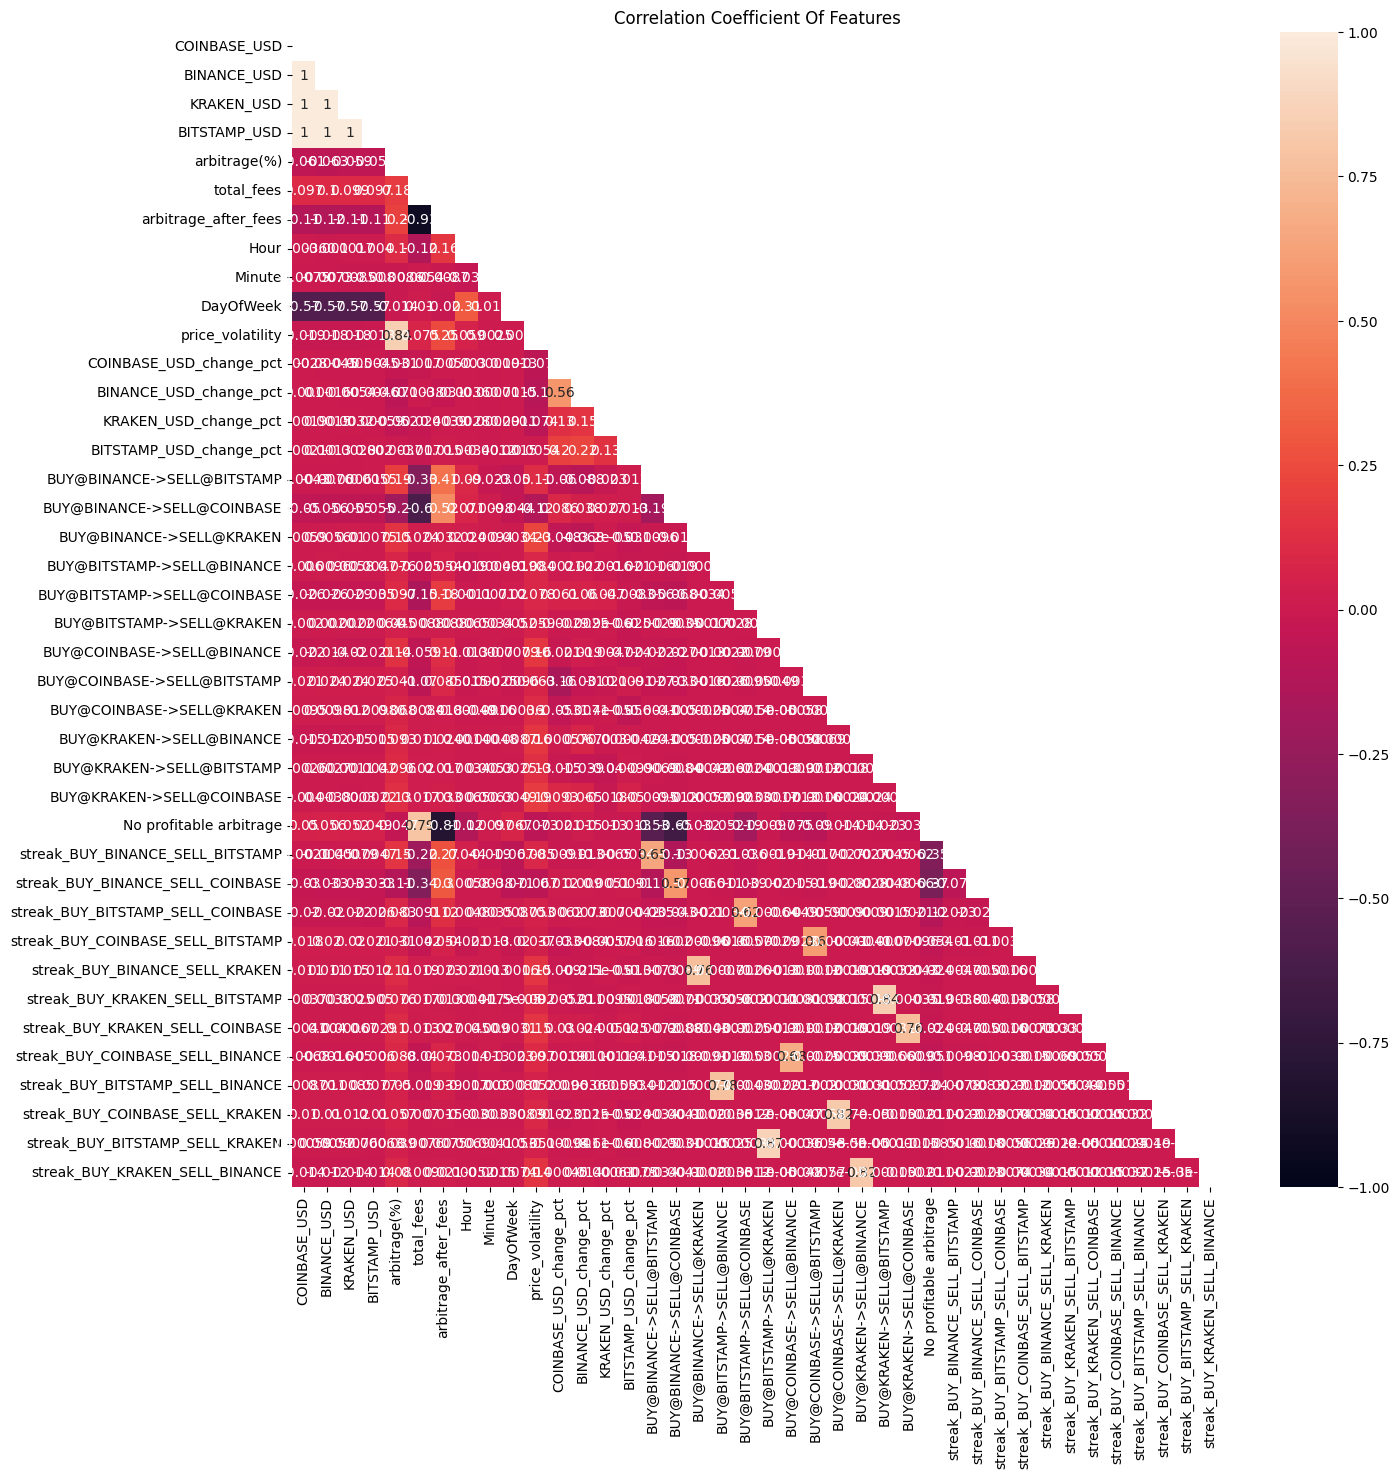

In [12]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# select numeric and bool columns from the dataframe
tmp = df.select_dtypes(include=['number','bool'])

# set figure size
plt.figure(figsize=(15,15))

# Generate a mask to onlyshow the bottom left triangle
mask = np.triu(np.ones_like(tmp.corr(), dtype=bool))

# generate heatmap
sns.heatmap(tmp.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Features')
plt.show()

In [ ]:
df.head()

## Setting Up the Experiment for Model evaluation

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.dummy import DummyClassifier

In [14]:
# Drop rows with NaN values in next_strategy (first & last row)
df = df.dropna()

# price_columns = [col for col in df.columns if col.endswith('_USD')]

# Drop non-numeric columns that shouldn't be in the model
X = df.drop(columns=['next_strategy',
                    #   'timestamp',
                      'arbitrage(%)', 'strategy','arbitrage_after_fees',
                    #  'Hour', 'Minute', 'DayOfWeek', 
                     'total_fees'])


y = df['next_strategy']

## Feature and Target Variable Selection

Here we define our predictor variables (X) and target variable (y):

- X: All numeric features excluding timestamp, strategy details, and time components
- y: The 'next_strategy' column representing the optimal arbitrage strategy in the next time period

We're also removing any rows with NaN values in the target variable, which typically occurs at the very beginning and end of the dataset.

In [ ]:
X.head()

## Creating a Baseline Classifier Based on the previous
To setup a Baseline, I will create a classifier model that will act as a baseline that just choses the class that appeared in the previous instance


In [ ]:
class BaselinePrev:
    def predict(self, X_test, y_test):
        """
        Predicts the next strategy based on the previous row's strategy.
        """
        # Use the last known strategy as the prediction for all rows
        if len(y_test) == 0:
            return []
        return [y_test.iloc[-1]] * len(X_test)

In [ ]:
models = {
    "baseline" : DummyClassifier(strategy='most_frequent', random_state=42),
    "baseline_prev" : DummyClassifier(strategy='prior', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=10, probability=True, random_state=42))
    ]),
    
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42))
    ]),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5, 
        random_state=42
    ),
    
#     "Neural Network": Pipeline([
#         ('scaler', StandardScaler()),
#         ('mlp', MLPClassifier(
#             hidden_layer_sizes=(100, 50), 
#             activation='relu',
#             solver='adam', 
#             max_iter=300,
#             random_state=42
#         ))
#     ])
}

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# predictions = {}

# for name, model in models.items():
#     print(f"\nModel: {name}")
#     accs = []

#     for train_idx, test_idx in kf.split(X, y):
#         X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#         y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_test, y_pred)
#         accs.append(acc)

#         # print(y_pred[:10])

#     print(f"Mean Accuracy: {(np.mean(accs)*100):.4f}%")


Model: baseline
Mean Accuracy: 64.0778%

Model: baseline_prev
Mean Accuracy: 64.0778%

Model: Random Forest
Mean Accuracy: 90.6920%

Model: SVM
Mean Accuracy: 91.0181%

Model: Logistic Regression


/Users/kurtik/Union College/SPRING 25/ML Project crypto-arbitrage/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kurtik/Union College/SPRING 25/ML Project crypto-arbitrage/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alt

Mean Accuracy: 84.0663%

Model: Gradient Boosting


KeyboardInterrupt: 

## Trade simulator for evaluation
Using a trade simluator class, we are going to evaluate beyond just accuracy -- I am deciding to use a trade simulator that will essentially simulate the trade that the model suggest (with all fees encountered along the way) and keep track of the net profits/losses to report for all my models. Being accurate isn't really enough here for comparison, it comes more so down to the ability to make the most money or have the least loss.

## Feature Encoding 

Our target variable 'next_strategy' is categorical, representing different arbitrage paths between exchanges. While we could use one-hot encoding to convert these categories into binary features, we'll treat this as a multi-class classification problem where each strategy is a distinct class.

Before building models, we'll examine feature correlations to identify potential redundancies and relationships in our data.

In [ ]:
from trade_sim import TradeSimulator

trade_simulator = TradeSimulator()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for name, model in models.items():
    if name == "baseline":
        continue  # Skip baseline models for trade simulation
    print(f"\nModel: {name}")
    total_profit = 0
    trade_count = 0
    successful_trades = 0
    
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Simulate trades for each prediction
        for i, pred_strategy in enumerate(y_pred):
            # Get corresponding row from X_test for this prediction
            row_data = X_test.iloc[i]
            
            # Parse the strategy to get buy and sell exchanges
            buy_exchange, sell_exchange = trade_simulator.parse_strategy(pred_strategy)
            
            if buy_exchange and sell_exchange:  # Only process valid strategies
                # Get corresponding prices from the row data
                buy_price = row_data[f"{buy_exchange}_USD"]
                sell_price = row_data[f"{sell_exchange}_USD"]
                
                # Simulate the trade
                profit = trade_simulator.simulate(pred_strategy, buy_price, sell_price)
                total_profit += profit
                trade_count += 1
                
                if profit > 0:
                    successful_trades += 1
    
    # Calculate statistics
    avg_profit_per_trade = total_profit / trade_count if trade_count > 0 else 0
    success_rate = (successful_trades / trade_count * 100) if trade_count > 0 else 0
    
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Trades Executed: {trade_count}")
    print(f"Profitable Trades: {successful_trades} ({success_rate:.2f}%)")
    print(f"Average Profit per Trade: ${avg_profit_per_trade:.2f}")



## Time Series Cross-Validation

StratifiedKFold with shuffling is problematic for time series data like our cryptocurrency price data because:

1. It breaks the temporal dependencies in the data
2. It creates data leakage by using future data to predict past events
3. It doesn't reflect real-world trading scenarios where you only have access to past data

A more appropriate approach for time series data is to use `TimeSeriesSplit`, which respects the temporal order of the data by ensuring that validation sets are always chronologically after the training sets.

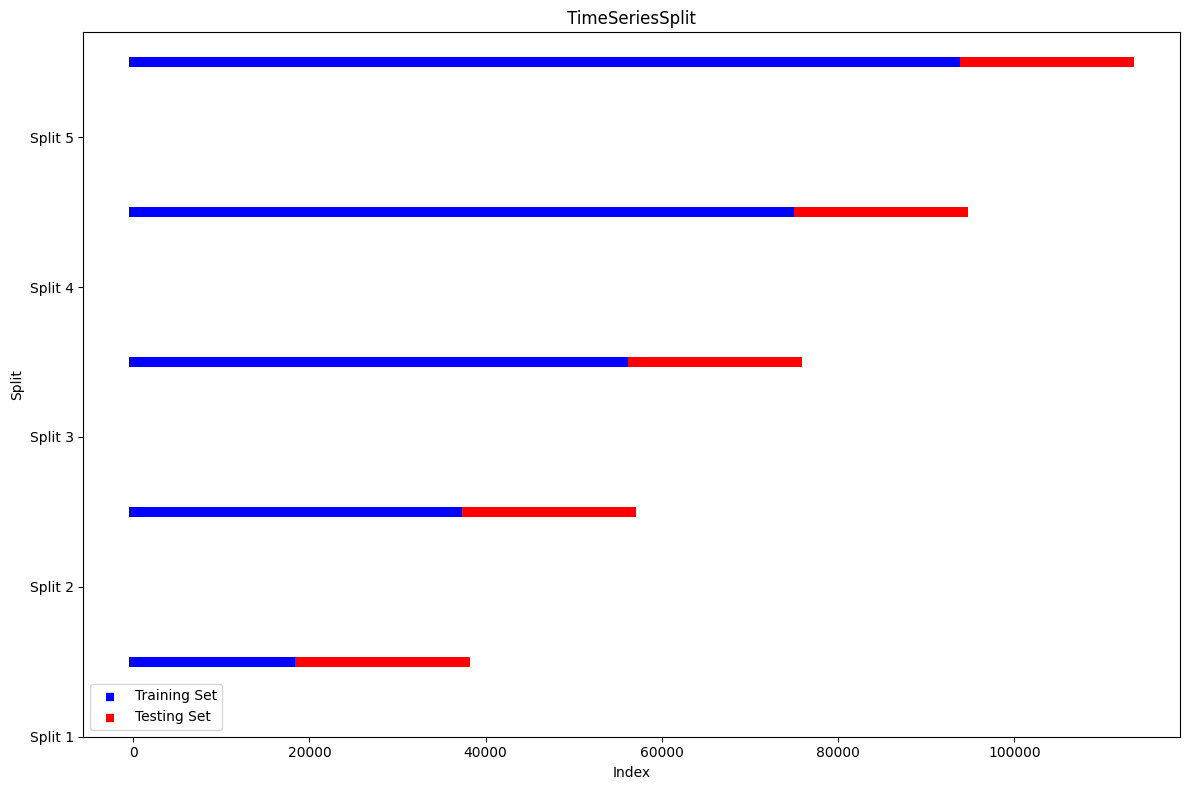

In [16]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Reset the index to visualize the splits better
df_reset = df.reset_index()

# Create TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Visualize the time series splits
plt.figure(figsize=(12, 8))
for i, (train_index, test_index) in enumerate(tscv.split(df_reset)):
    plt.scatter(df_reset.iloc[train_index].index, 
              [i + 0.5] * len(train_index), 
              c='blue', 
              marker='_', 
              lw=6,
              label='Training Set' if i == 0 else '')
              
    plt.scatter(df_reset.iloc[test_index].index, 
              [i + 0.5] * len(test_index), 
              c='red', 
              marker='_', 
              lw=6,
              label='Testing Set' if i == 0 else '')

plt.yticks(range(5), ['Split {}'.format(i + 1) for i in range(5)])
plt.xlabel('Index')
plt.ylabel('Split')
plt.legend(loc='best')
plt.title('TimeSeriesSplit')
plt.tight_layout()
plt.show()

## Final Model Evaluation with Time Series Cross-Validation and Profit Simulation

In this final evaluation, we combine proper time series cross-validation with realistic trade simulation to assess model performance. For each model:

1. We train on chronologically ordered data using TimeSeriesSplit
2. We evaluate both prediction accuracy and simulated trading profits
3. We track success rate, total profits, and average profit per trade

This comprehensive evaluation approach ensures we select models that not only predict the correct arbitrage strategy but also generate actual profits when trading fees and execution are taken into account.

In [ ]:
# Re-implement model evaluation and trade simulation with TimeSeriesSplit
from trade_sim import TradeSimulator

trade_simulator = TradeSimulator()
tscv = TimeSeriesSplit(n_splits=5)

model_results = {}

for name, model in models.items():
    if name == "baseline":
        continue  # Skip baseline models for trade simulation
        
    print(f"\nModel: {name}")
    total_profit = 0
    trade_count = 0
    successful_trades = 0
    accs = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        accs.append(acc)
        
        # Simulate trades for each prediction
        split_profit = 0
        split_trades = 0
        split_successful = 0
        
        for i, pred_strategy in enumerate(y_pred):
            # Get corresponding row from X_test for this prediction
            row_data = X_test.iloc[i]
            
            # Parse the strategy to get buy and sell exchanges
            buy_exchange, sell_exchange = trade_simulator.parse_strategy(pred_strategy)
            
            if buy_exchange and sell_exchange:  # Only process valid strategies
                # Get corresponding prices from the row data
                buy_price = row_data[f"{buy_exchange}_USD"]
                sell_price = row_data[f"{sell_exchange}_USD"]
                
                # Simulate the trade
                profit = trade_simulator.simulate(pred_strategy, buy_price, sell_price)
                total_profit += profit
                split_profit += profit
                trade_count += 1
                split_trades += 1
                
                if profit > 0:
                    successful_trades += 1
                    split_successful += 1
        
        # Print split results
        split_avg_profit = split_profit / split_trades if split_trades > 0 else 0
        split_success_rate = (split_successful / split_trades * 100) if split_trades > 0 else 0
        print(f"Split Results - Accuracy: {acc:.4f}, Profit: ${split_profit:.2f}, Success Rate: {split_success_rate:.2f}%")
    
    # Calculate overall statistics
    avg_profit_per_trade = total_profit / trade_count if trade_count > 0 else 0
    success_rate = (successful_trades / trade_count * 100) if trade_count > 0 else 0
    mean_accuracy = np.mean(accs)
    
    print(f"Overall Results:")
    print(f"Mean Accuracy: {(mean_accuracy*100):.4f}%") 
    print(f"Total Profit: ${total_profit:.2f}")
    print(f"Trades Executed: {trade_count}")
    print(f"Profitable Trades: {successful_trades} ({success_rate:.2f}%)")
    print(f"Average Profit per Trade: ${avg_profit_per_trade:.2f}")

# Save results
    model_results[name] = {
        'accuracy': mean_accuracy,
        'total_profit': total_profit,
        'trades_executed': trade_count,
'profitable_trades': successful_trades,
        'success_rate': success_rate,
        'avg_profit_per_trade': avg_profit_per_trade
    }


Model: baseline_prev
Split Results - Accuracy: 0.7308, Profit: $0.00, Success Rate: 0.00%
Split Results - Accuracy: 0.6627, Profit: $0.00, Success Rate: 0.00%
Split Results - Accuracy: 0.7004, Profit: $0.00, Success Rate: 0.00%
Split Results - Accuracy: 0.4990, Profit: $0.00, Success Rate: 0.00%
Split Results - Accuracy: 0.4383, Profit: $0.00, Success Rate: 0.00%
Overall Results:
Mean Accuracy: 60.6236%
Total Profit: $0.00
Trades Executed: 0
Profitable Trades: 0 (0.00%)
Average Profit per Trade: $0.00

Model: Random Forest
Split Results - Accuracy: 0.7611, Profit: $24643.93, Success Rate: 99.82%
Split Results - Accuracy: 0.8609, Profit: $140813.17, Success Rate: 99.96%
Split Results - Accuracy: 0.9105, Profit: $143794.06, Success Rate: 99.83%
Split Results - Accuracy: 0.8824, Profit: $280815.51, Success Rate: 99.78%
Split Results - Accuracy: 0.8871, Profit: $307314.77, Success Rate: 99.95%
Overall Results:
Mean Accuracy: 86.0420%
Total Profit: $897381.45
Trades Executed: 30150
Profita